# Машинное обучение, ФКН ВШЭ

# Практическое задание 2

## Общая информация

Дата выдачи: 11.10.2016

Срок сдачи: 24.10.2016 23:59MSK

### О задании
На сайтах для поиска работы можно найти сотни тысяч объявлений, каждое из которых состоит из пространного описания вакансии и предлагаемой зарплаты. Есть ли связь между описанием и зарплатой? Существуют ли определенные слова, которые наиболее сильно характеризуют зарплату? Можно ли найти другие информативные факторы? Вам предстоит ответить на эти вопросы, проанализировав выборку объявлений о работе в Великобритании.

Практическое задание 2 посвящено работе с текстовыми данными и категориальными признаками и задачам бинарной классификации. Вы научитесь:
 * работать с категориальными признаками;
 * строить вещественные представления текстовых данных;
 * обучать и строить прогнозы линейных классификаторов при помощи scikit-learn и Vowpal Wabbit;
 * тестировать модели и проводить оценку качества в задачах бинарной классификации.


### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Кроме того, некоторые из заданий являются опциональными (необязательными), однако за их выполнение можно получить дополнительные баллы, которые позднее будут учитываться при проставлении оценок автоматом по курсу.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW2_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW2_IvanovII.ipynb*). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

## Данные

Как было упомянуто ранее, в рамках данного задания мы будем решать задачу бинарной классификации для предсказания уровня заработной платы по тексту объявления о вакансии на примере набора данных с соревнования [Adzuna - Job Salary Prediction](https://www.kaggle.com/c/job-salary-prediction). Для начала пройдите по [ссылке](https://www.kaggle.com/c/job-salary-prediction/data) и скачайте файл Train_rev1 (при необходимости, зарегистрируйтесь на Kaggle).

Посмотрим на данные в файле и загрузим их в DataFrame:

In [3]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [4]:
# print first 2 rows from Train_rev1.csv
!head -n 2 Train_rev1.csv

In [5]:
df = pd.read_csv('Train_rev1.csv', sep=',')
print df.shape
df.head()

(244768, 12)


,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


В оригинальной постановке предлагается рассматривать признак SalaryNormalized как целевой и решать задачу регрессии, однако в рамках данного задания мы сведём её к задаче бинарной классификации, разделив объекты на 2 группы: объявления о вакансиях с низкой и высокой зарплатами соответственно.

<img src = "http://salt.uaa.alaska.edu/kath/kti/mean_median2.gif">

В качестве порога разбиения объектов на группы будем рассматривать медиану признака SalaryNormalized. Заметим, что таким образом мы автоматически получим задачу классификации со сбалансированными классами:

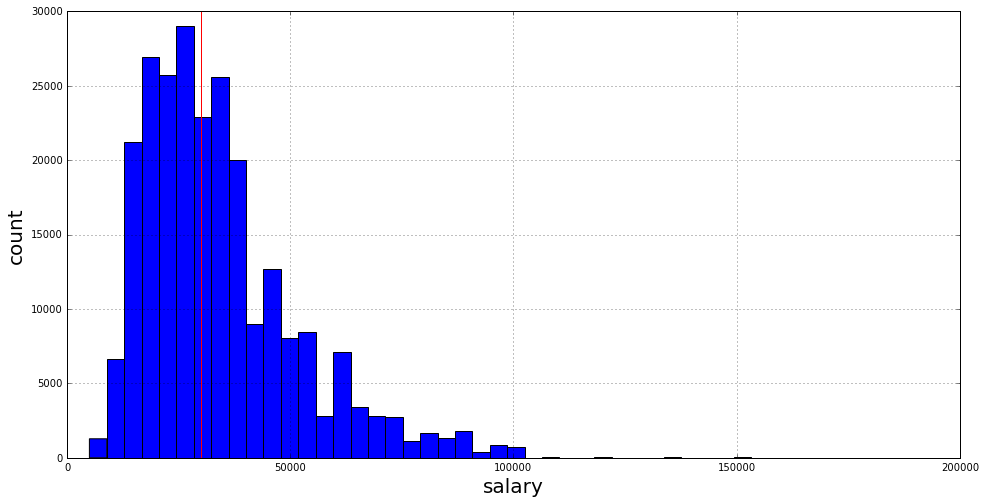

In [6]:
# salary histogramm
median = np.median(df['SalaryNormalized'])

figsize(16,8)
plt.hist(df['SalaryNormalized'], bins=50)
plt.axvline(median, c='r')
plt.xlabel('salary', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.grid()

Осуществим последние шаги по подготовке датасета:
- бинаризуем признак SalaryNomalized по описанному ранее порогу;
- исключим из выборки признак SalaryRaw, чтобы устранить утечку целевой переменной в признаки.

In [7]:
df['SalaryNormalized'] = (df['SalaryNormalized'] > median).astype(int)
df.drop('SalaryRaw', axis=1, inplace=True)
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,0,cv-library.co.uk


#### 1. (0 баллов) Разбейте получившуюся выборку на обучающую и контрольную в соотношении 70/30 с использованием перемешивания объектов.

При разбиении используйте значение параметра random_state=42.

In [8]:
from sklearn.model_selection import train_test_split 
df_train, df_test = train_test_split(df, test_size=.3, random_state=42)

del df

## Векторизация

Как правило, модели, используемые в машинном обучении, применяются в предположении, что матрица "объект-признак" является вещественнозначной. Поэтому при работе с категориальными признаками и текстами сперва их необходимо привести к вещественному виду.

Заметим, что в нашей задаче есть признаки, являющиеся текстами произвольной природы (Title, FullDescription), и категориальные признаки, принимающие ограниченное число значений (ContractType, Category и др.).

Самый простой и понятный способ преобразования текстовых данных — векторизация. В этом случае для каждого слова, встречающегося в некотором набре текстов мы создаём отдельный новый признак, который будет равен $1$, когда слово встречается в заданном объекте, и $0$ – в противном случае.

#### 2. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, осуществив векторизацию получившихся текстов при помощи [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [9]:
columns = ['Title', 'FullDescription', 'LocationRaw', 'LocationNormalized', 'ContractTime', 'Company', 'Category', 'SourceName', 'ContractType']

In [8]:
for  df in df_train, df_test:
    df['Text'] = df[columns].apply(lambda row: ' '.join(x if type(x) != float or not np.isnan(x) else '' for x in row), axis=1)
    #df.drop(columns, axis=1, inplace=True)

del df # not to get confused

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vec = CountVectorizer(stop_words='english', dtype=np.int16) # in reality the biggest number is 212

In [10]:
X_train = vec.fit_transform(df_train['Text'])
X_test = vec.transform(df_test['Text'])


In [12]:
y_train = np.array(df_train['SalaryNormalized'], dtype=np.bool)
y_test = np.array(df_test['SalaryNormalized'], dtype=np.bool)

#### 3. (1.5 балла) Обучите следующие модели на обучающей выборке:
 - [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
 - логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [19]:
from sklearn.linear_model import LogisticRegression
cls = LogisticRegression()

cls.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Volkswagen time!

In [43]:
words = vec.get_feature_names()

In [21]:
def store_vw_data(file_name, X, y=None):
    with open(file_name, 'w') as f:
        for row_idx in xrange(X.shape[0]):
            row = X.getrow(row_idx)
            row_nz = row.nonzero()[1]
            s = '|txt ' + ' '.join(words[word_idx] + ':' + str(row[0, word_idx]) for word_idx in row_nz).encode("ascii", "ignore")
            if y is not None:
                print >> f, y[row_idx] * 2 - 1, s
            else:
                print >> f, s

In [15]:
with open('train.txt', 'w') as f:
    for row_idx in xrange(X_train.shape[0]):
        row = X_train.getrow(row_idx)
        row_nz = row.nonzero()[1]
        s = u' '.join(words[word_idx] + ':' + str(row[0, word_idx]) for word_idx in row_nz).encode("ascii", "ignore")
        print >> f, y_train[row_idx] * 2 - 1, u'|txt', s

In [40]:
!vw --data train.txt --loss_function logistic --link logistic -f model.vw

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      194
0.646836 0.600524            2            2.0  -1.0000   0.4515       66
0.558552 0.470269            4            4.0  -1.0000   0.3270      126
0.846570 1.134587            8            8.0  -1.0000   0.3939       97
0.757598 0.668626           16           16.0  -1.0000   0.5116      119
0.751379 0.745160           32           32.0  -1.0000   0.6702      167
0.699284 0.647190           64           64.0  -1.0000   0.2022      192
0.677567 0.655849          128          128.0  -1.0000   0.3876      188
0.638811 0.600055          256          256.0  -1.0000   0.2825       90
0.600354 0.561896          512          5

#### 4. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 3 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

Для sklearn:

In [17]:
y_predict = cls.predict_proba(X_test)[:,1]

In [10]:
from sklearn import metrics

In [19]:
print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict > .5)

accuracy: 0.878975
ROC-AUC: 0.945126
F1 score: 0.874840
Confusion matrix:
[[33485  4455]
 [ 4432 31059]]


Для vw:

In [65]:
store_vw_data('test.txt', X_test)
!rm test.txt.cache

NameError: name 'store_vw_data' is not defined

In [ ]:
!vw -t -c -i model.vw -p out test.txt

In [ ]:
y_predict_vw = np.loadtxt('out')

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict_vw > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict_vw)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict_vw > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict_vw > .5)

Обе модели имеют (почти) одинаковое качество работы
При этом различия в следующем:
1. VW использует 1 проход
2. VW не имеет регуляризации

Но в целом ничего удивительного в том, что схожие модели дают схожие результаты нет

#### 5. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 2. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретируйте полученный результат.

In [51]:
cls.coef_.size

168433

In [54]:
important = range(cls.coef_.size)
important.sort(key=lambda x: cls.coef_[0,x], reverse=True)
print '10 best words to meet in the description:', ' '.join(words[x] for x in important[:10])

10 most important words: theladders nhsd a24 targetjobs noreen hcpc prestigenursing exert apl redmond


Интерпретируем: Ladders, Inc. is a United States-based company providing an online job search service. It launched listing only vetted job offers with annual salaries of $100,000 or more.

In [63]:
median < 100000

True

In [56]:
print '10 worst words to meet in the description:', ' '.join(words[x] for x in important[-10:])

10 worst words to meet in the description: collates tssr omar 88 phocas juniorbroker nijobfinder bv studentship elance


In [ ]:
!grep -i collates Train_rev1.csv | head -1

Скорее всего работа, которая требует внимания - что-то не требующее особого образования. (Output клетки очищен потому, что он длинный и неприятный

#### 6. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 2 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

vw-varinfo, конечно, учит модель заново, но по-другому придётся заниматься очень неприятным разбором текста

In [70]:
!~/vowpal_wabbit/utl/vw-varinfo --loss_function logistic --link logistic -c train.txt > varinfo

In [72]:
!head varinfo

FeatureName                                                                                                                                                   	   HashVal   MinVal   MaxVal    Weight   RelScore
txt^theladders                                                                                                                                                	    143200     0.00     1.00   +1.3495    100.00%
txt^optometrist                                                                                                                                               	     11461     0.00    11.00   +0.9387     69.56%
txt^samplying                                                                                                                                                 	     11461     0.00     1.00   +0.9387     69.56%
txt^hcpc                                                                                                                                                      	    1

В целом тут всё то же самое, optometrist на втором месте скорее всего - эффект от overfitting

In [74]:
!grep optometrist Train_rev1.csv | wc -l

437


Или нет?

In [84]:
opt_weight = cls.coef_[0, vec.transform(['optometrist']).nonzero()[1][0]]
opt_weight

1.7028264931259287

In [85]:
np.sum(cls.coef_ > opt_weight)

28

Ну ладно, там он тоже на хорошем месте

In [86]:
!tail varinfo

txt^jobcentre                                                                                                                                                 	     49928     0.00     5.00   -0.7380    -54.69%
txt^cpcs                                                                                                                                                      	     37758     0.00     7.00   -0.7691    -56.99%
txt^graduate                                                                                                                                                  	    190324     0.00    34.00   -0.9852    -73.00%
txt^kfrimley12month_job                                                                                                                                       	    190324     0.00     1.00   -0.9852    -73.00%
txt^usfos                                                                                                                                                     	    1

Здесь всё тоже ясно - ассистентам платят мало, временно занятым платят мало, вчерашним студентам платят мало

новости из гугла: A chef de partie, station chef, or line cook, is a chef in charge of a particular area of production in a restaurant. In large kitchens, each chef de partie might have several cooks or assistants.

In [91]:
!grep -i kfrimley12month_job Train_rev1.csv | wc -l

1


А вот это overfitting чистой воды - у нас же нет регуляризации, 1 проход, конечно, отчасти спасает от подобных спецэффектов, но не до конца

## TF-IDF

Ещё один способ работы с текстовыми данными — [TF-IDF](https://en.wikipedia.org/wiki/Tf–idf) (**T**erm **F**requency–**I**nverse **D**ocument **F**requency). Рассмотрим коллекцию текстов $D$.  Для каждого уникального слова $t$ из документа $d \in D$ вычислим следующие величины:

1. Term Frequency – количество вхождений слова в отношении к общему числу слов в тексте:
$$\text{tf}(t, d) = \frac{n_{td}}{\sum_{t \in d} n_{td}},$$
где $n_{td}$ — количество вхождений слова $t$ в текст $d$.
1. Inverse Document Frequency
$$\text{idf}(t, D) = \log \frac{\left| D \right|}{\left| \{d\in D: t \in d\} \right|},$$
где $\left| \{d\in D: t \in d\} \right|$ – количество текстов в коллекции, содержащих слово $t$.

Тогда для каждой пары (слово, текст) $(t, d)$ вычислим величину:
$$\text{tf-idf}(t,d, D) = \text{tf}(t, d)\cdot \text{idf}(t, D).$$

Отметим, что значение $\text{tf}(t, d)$ корректируется для часто встречающихся общеупотребимых слов при помощи значения $\text{idf}(t, D).$

Признаковым описанием одного объекта $d \in D$ будет вектор $\bigg(\text{tf-idf}(t,d, D)\bigg)_{t\in V}$, где $V$ – словарь всех слов, встречающихся в коллекции $D$.

#### 7. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения всех признаков каждого объекта выборки через символы пробела. После этого получите признаковое описание объектов, вычислив вектор tf-idf для каждого объекта помощи [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), обучив его на обучающей выборке и применив на контрольной.

In [93]:
vec = TfidfVectorizer(stop_words='english')
X_train = vec.fit_transform(df_train['Text'])
X_test = vec.transform(df_test['Text'])

y_train = np.array(df_train['SalaryNormalized'], dtype=np.bool)
y_test = np.array(df_test['SalaryNormalized'], dtype=np.bool)

#### 8. (0 баллов) Обучите следующие модели на обучающей выборке:
- [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из модуля sklearn с параметрами по умолчанию;
- логистическую регрессию при помощи Vowpal Wabbit с параметрами по умолчанию.

In [94]:
cls = LogisticRegression()

cls.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [95]:
store_vw_data('train-tfidf.txt', X_train, y_train)
store_vw_data('test-tfidf.txt', X_test)

In [104]:
!vw --data train-tfidf.txt --loss_function logistic --link logistic -f model.vw

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = train-tfidf.txt
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      194
0.614733 0.536320            2            2.0  -1.0000   0.4151       66
0.525927 0.437121            4            4.0  -1.0000   0.3150      126
0.699164 0.872401            8            8.0  -1.0000   0.4148       97
0.671989 0.644813           16           16.0  -1.0000   0.5010      119
0.698374 0.724760           32           32.0  -1.0000   0.6439      167
0.672396 0.646418           64           64.0  -1.0000   0.2214      192
0.655620 0.638844          128          128.0  -1.0000   0.4130      188
0.625681 0.595742          256          256.0  -1.0000   0.3192       90
0.588950 0.552219          512     

#### 9. (0.5 балла) Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для каждой из построенных в п. 8 моделей на контрольной выборке. Сравните построенные модели по качеству их работы.

Для sklearn:

In [105]:
y_predict = cls.predict_proba(X_test)[:,1]

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict > .5)

Для vw:

In [107]:
!vw -t -c -i model.vw -p out test-tfidf.txt

only testing
predictions = out
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using cache_file = test-tfidf.txt.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.000000 0.000000            1            1.0  unknown   0.5227      163
0.000000 0.000000            2            2.0  unknown   0.0988      194
0.000000 0.000000            4            4.0  unknown   0.2879       30
0.000000 0.000000            8            8.0  unknown   0.0389      104
0.000000 0.000000           16           16.0  unknown   0.6878      194
0.000000 0.000000           32           32.0  unknown   0.6592      123
0.000000 0.000000           64           64.0  unknown   0.9837       90
0.000000 0.000000          128          128.0  unknown   0.9363      118
0.000000 0.000000          256          256.0  unknown   0.6528      1

In [108]:
y_predict_vw = np.loadtxt('out')

In [109]:
print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict_vw > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict_vw)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict_vw > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict_vw > .5)

accuracy: 0.872438
ROC-AUC: 0.944684
F1 score: 0.868789
Confusion matrix:
[[33053  4887]
 [ 4480 31011]]


И снова две модели имеют очень близкие характеристики качества работы

#### 10. (0.5 балла) Сравните значения метрик из п. 9 со значениями, полученными в п. 5, и сравните соответствующие модели по качеству из работы.

**Ответ**: Ой, ну (почти) никакой разницы нет

#### 11. (1 балл) Отсортируйте веса признаков для модели логистической регрессии из scikit-learn, полученной в п. 8. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [113]:
important = range(cls.coef_.size)
important.sort(reverse=True, key=lambda x: cls.coef_[0, x])

In [114]:
print '10 best words:', ' '.join(words[w] for w in important[:10])

10 best words: optometrist director manager senior head theladders hcpc london locum leadership


Я даже не готов комментировать - большинство из этих слов мы уже так или иначе видели. Да, менеджерам на высоких позициях, людям с большим опытом работы платят больше. optometrist меня немного удивляет, но просто их довольно много в тестовых данных и модель очень уверена, что этим людям платят много

In [115]:
print '10 worst words:', ' '.join(words[w] for w in important[-10:])

10 worst words: myukjobs nijobfinder aat library partie nvq junior jobcentre graduate assistant


И снова ничего удивительного - работы не требующие опыта или образования оплачиваются плохо, указаны всякие места, в которых не бывают высокооплачиваемые вакансии

#### 12. (0.5 доп. балла) Отсортируйте веса признаков для модели логистической регрессии, полученной в п. 8 при помощи Vowpal Wabbit. Какие слова из встречающихся в выборке имеют наибольшее/наименьшее влияние на значение целевой переменной? Проинтерпретирйте полученный результат.

In [116]:
!~/vowpal_wabbit/utl/vw-varinfo --loss_function logistic --link logistic -c train-tfidf.txt > varinfo

In [118]:
!head varinfo

FeatureName                                                                                                                                                   	   HashVal   MinVal   MaxVal    Weight   RelScore
txt^theladders                                                                                                                                                	    143200     0.00     0.20  +15.4606    100.00%
txt^navisionjobs                                                                                                                                              	     18796     0.00     0.06   +9.0283     58.40%
txt^technicalsalesmanagerpigmentsfillerstosurfacecoatings_job                                                                                                 	    131696     0.00     0.05   +8.0391     52.00%
txt^cvbar                                                                                                                                                     	     

О. Похоже, tf-idf намного больше смотрит на источник вакансии, чем на какие-то слова в её описании
Похоже, tf-idf просто уменьшает влияние часто встречающихся слов в текстах - у них очень маленький idf

In [120]:
!grep -i technicalsalesmanagerpigmentsfillerstosurfacecoatings Train_rev1.csv | wc -l

13


ВАУ. Это не вполне overfit. Что же это такое?

In [ ]:
!grep -i technicalsalesmanagerpigmentsfillerstosurfacecoatings Train_rev1.csv 

(Очистил вывод, чтобы не загромождать ноутбук)
А. Ну всё ясно. Просто это 13 одинаковых вакансий, возможно на разных сайтах. А слово уникально. Обидно. Будь это соревнование, возможно стоило бы почистить данные от такого

## Счётчики

Ранее в рамках данного задания при построении моделей мы объединяли значения всех признаков в единую строку, что предполагает равноправность всех признаков. Однако заметим, что в этом случае мы допускаем потерю информации: слово "Glasgow" может по-разному влиять на зарплату, если оно находится в названии объявления и в геолокации. Чтобы устранить этот недостаток, при создании текстового описания объекта будем объединять только значения признаков Title и FullDescription, а остальные будем рассматривать как категориальные. При этом с полученным текстовым описанием объекта будем работать, как раньше (при помощи векторизации или tf-idf), а для кодирования категориальных признаков используем **счётчики**.

Идея этого метода состоит в том, чтобы заменить значение категориального признака на вероятность того, что объект с данным значением признака относится к положительному классу. Опишем эту идею более формально. Пусть у нас есть выборка $X = \{ (x_i, y_i) \}_{i=1}^l,$ и $j$-ый признак принимает значения из множества $U_j = \{ u_{jn}\}_{n=1}^{N_j},$ где $N_j$ — количество различных значений $j$-ого признака. Пусть $x_{ij} = u_{jn},$ тогда заменим значения $j$-ого категориального признака объекта $x_i$ на следующую оценку: 
$$\hat{P}(y_i=+1|x_{ij}=u_{jn}) = \frac{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1}^l \left[ x_{mj} = u_{jn} \right]}.$$

Однако заметим, что при таком способе формирования счётчиков мы учитываем в формуле для объекта $x_i$ его метку $y_i$, тем самым вносим информацию об ответе в признаки. Чтобы устранить этот недостаток, при вычислении счётчика будем исключать из рассмотрения текущий объект, т.е. рассматривать следующую оценку:
$$\hat{P}(y_i=+1|X_{ij}=u_{jn}) = \frac{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right] \left[ y_m = +1 \right]}{\sum_{m=1, \\ m \ne i}^l \left[ x_{mj} = u_{jn} \right]},$$

#### 13. (0.5 балла) Создайте текстовое описание объектов обучающей и контрольной выборок, объединив значения признаков Title и FullDescription каждого объекта выборки через символ пробела, после чего перейдите к признаковому описанию объектов, вычислив вектор tf-idf аналогично п. 7.

In [10]:
def get_value(x):
    if type(x) is float and np.isnan(x):
        return ' ' #probably I have to use something like 'nan' here
    return x

In [11]:
for  df in df_train, df_test:
    df['Text'] = df.apply(lambda row: get_value(row['Title']) + ' ' + 
                                   get_value(row['FullDescription']), axis=1)
    #df.drop(columns, axis=1, inplace=True)

del df # not to get confused

In [12]:
vec = TfidfVectorizer(stop_words='english')
X_train_tfidf = vec.fit_transform(df_train['Text'])
X_test_tfidf = vec.transform(df_test['Text'])

#### 14. (1 балл) Закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи [one-hot encoding](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

In [13]:
from sklearn.feature_extraction import DictVectorizer
cols = [x for x in columns if x not in ['Title', 'FullDescription']]
vec = DictVectorizer(dtype=np.float32)
X_train_one_hot = vec.fit_transform(df_train[cols].fillna('NaN').to_dict(orient='records'))
X_test_one_hot = vec.transform(df_test[cols].fillna('NaN').to_dict(orient='records'))

In [19]:
from scipy import sparse

In [16]:
X_train = sparse.hstack((X_train_tfidf, X_train_one_hot))
X_test = sparse.hstack((X_test_tfidf, X_test_one_hot))

In [18]:
cls = LogisticRegression()
cls.fit(X_train, y_train)

In [22]:
y_predict = cls.predict_proba(X_test)[:,1]

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict > .5)

accuracy: 0.872547
ROC-AUC: 0.945792
F1 score: 0.868677
Confusion matrix:
[[33118  4822]
 [ 4537 30954]]


#### 15. (2 балла) Для выборки, полученной в п. 13, закодируйте категориальные признаки (все, кроме Title и FullDescription) при помощи счётчиков, после чего обучите логистическую регрессию (при помощи scikit-learn или Vowpal Wabbit) на обучающей выборке. Вычислите значения ROC-AUC, [F-меры](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), а также постройте [матрицу ошибок](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) для полученной модели на контрольной выборке. 

Уделите внимание оптимальности вычисления счётчиков!

In [15]:
from collections import Counter
counter_total = {x: Counter() for x in cols}
counter_hit = {x: Counter() for x in cols}

In [16]:
for col in  cols:
    for idx in df_train.index:
        val = df_train[col][idx]
        counter_total[col][val] += 1
        if df_train['SalaryNormalized'][idx] == 1:
            counter_hit[col][val] += 1

In [17]:
k_reg = 1.

In [18]:
col_map = {x: cols.index(x) for x in cols}
X_train_counter = np.zeros(df_train[cols].shape, dtype=np.float32)
for col in  cols:
    for idx_num, idx in enumerate(df_train.index):
        val = df_train[col][idx]
        total = counter_total[col][val] - 1
        hit = counter_hit[col][val]
        if df_train['SalaryNormalized'][idx] == 1:
            hit -= 1
        X_train_counter[idx_num,col_map[col]] += (hit + k_reg * .5) / (total + k_reg)

In [22]:
X_test_counter = np.zeros(df_test[cols].shape, dtype=np.float32)
for col in  cols:
    for idx_num, idx in enumerate(df_test.index):
        val = df_test[col][idx]
        total = counter_total[col][val]
        hit = counter_hit[col][val]
        X_test_counter[idx_num,col_map[col]] += (hit + k_reg * .5) / (total + k_reg)

In [23]:
X_train = sparse.hstack((X_train_tfidf, X_train_counter))
X_test = sparse.hstack((X_test_tfidf, X_test_counter))

In [27]:
cls = LogisticRegression()
cls.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
y_predict = cls.predict_proba(X_test)[:,1]

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict > .5)

accuracy: 0.870722
ROC-AUC: 0.944242
F1 score: 0.866815
Confusion matrix:
[[33046  4894]
 [ 4599 30892]]


#### 16. (0.5 балла) Сравните значения метрик из п. 15 со значениями, полученными в п. 14, и сделайте вывод о качестве классификации для каждого из методов кодирования категориальных признаков.

**Ответ:** и всё ещё наплевать

## Подбор гиперпараметров

#### 17. (1.5 доп. балла) Разбейте обучающую выборку на обучающую и валидационную в отношении 80/20. Для выборки, полученной в п. 13, подберите оптимальное количество фолдов, используемое при кодировании категориальных признаков (всех, кроме Title и FullDescription), путём оптимизации значения accuracy на валидационной выборке. Используйте следующие модели, аналогично также подобрав оптимальные значения указанных гиперпараметров:
- логистическую регрессию из модуля sklearn с подбором коэффициента регуляризации;
- логистическую регрессию при помощи Vowpal Wabbit с подбором следующих гиперпараметров:
    - коэффициент регуляризации (--l2);
    - количество эпох (--passes);
    - длина градиентного шага (-l);
    - длина N-грамм (--ngram).

In [29]:
#оптимальность 1-фолда очевидна
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=.2)

In [39]:
cls = LogisticRegression(C=30) # Мне лень дружить GridSearchCV с train_test_split
cls.fit(X_train, y_train)
print 'train score: %f' % cls.score(X_train, y_train)
print 'cv score: %f' % cls.score(X_cv, y_cv)

train score: 0.948493
cv score: 0.879975


In [47]:
X_train_tfidf.shape

(171337, 165394)

In [48]:
def store_vw_new(file_name, X_tfidf, X_counter, y=None):
    with open(file_name, 'w') as f:
        for row_idx in xrange(X_tfidf.shape[0]):
            row = X_tfidf.getrow(row_idx)
            row_nz = row.nonzero()[1]
            s_tfidf = '|txt ' + ' '.join(words[word_idx] + ':' + str(row[0, word_idx]) for word_idx in row_nz).encode("ascii", "ignore")
            s_counter = '|cnt' + ' '.join(cols[i] + ':' + str(X_counter[row_idx, i]) for i in xrange(len(cols)))
            if y is not None:
                print >> f, y[row_idx] * 2 - 1, s_tfidf, s_counter
            else:
                print >> f, s_tfidf, s_counter

In [49]:
store_vw_new('train-cnt.txt', X_train_tfidf, X_train_counter, np.array(df_train['SalaryNormalized'], dtype=np.bool))

In [62]:
store_vw_new('test-cnt.txt', X_test_tfidf, X_test_counter)

In [73]:
!vw --data train-cnt.txt --loss_function logistic --link logistic -f model.vw --holdout_period 5 --passes 100 -c -l 1e-1

final_regressor = model.vw
Num weight bits = 18
learning rate = 0.1
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
using cache_file = train-cnt.txt.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.5000      195
0.490798 0.288449            2            2.0  -1.0000   0.2506       66
0.533497 0.576197            4            4.0  -1.0000   0.4237      127
0.606081 0.678664            8            8.0   1.0000   0.4435      105
0.656705 0.707330           16           16.0  -1.0000   0.4744      107
0.681880 0.707054           32           32.0  -1.0000   0.4530      103
0.668636 0.655393           64           64.0  -1.0000   0.5010      117
0.669991 0.671346          128          128.0  -1.0000   0.4089      225
0.657199 0.644407          256          256.0  -1.0

#### 18. (0.5 доп. балла) Обучите указанные выше модели на обучающей выборке для оптимальных значений гиперпараметров, найденных в п. 17, после чего для каждой из моделей вычислите значения ROC-AUC, F-меры, а также постройте матрицу ошибок на контрольной выборке. Как качество классификации при помощи полученных в данном разделе моделей соотносится с моделями, полученными в предыдущих разделах?

In [40]:
cls = LogisticRegression(C=30) # Мне лень дружить GridSearchCV с train_test_split
cls.fit(X_train, y_train)
y_predict = cls.predict_proba(X_test)[:,1]

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict > .5)

accuracy: 0.877667
ROC-AUC: 0.946503
F1 score: 0.873847
Confusion matrix:
[[33336  4604]
 [ 4379 31112]]


In [71]:
!vw -t -c -i model.vw -p out test-cnt.txt --quiet

In [72]:
y_predict_vw = np.loadtxt('out')

print 'accuracy: %f' % metrics.accuracy_score(y_test, y_predict_vw > .5)
print 'ROC-AUC: %f' % metrics.roc_auc_score(y_test, y_predict_vw)
print 'F1 score: %f' % metrics.f1_score(y_test, y_predict_vw > .5)
print 'Confusion matrix:'
print metrics.confusion_matrix(y_test, y_predict_vw > .5)

accuracy: 0.877763
ROC-AUC: 0.948717
F1 score: 0.873894
Confusion matrix:
[[33354  4586]
 [ 4390 31101]]


Комментарий про качество работы: ОНО НЕ РАСТЁТ ПАЧИМУ??? У меня есть объяснение почему регуляризация (почти) бесполезна: ну пусть мы выучили что слово technicalsalesmanagerpigmentsfillerstosurfacecoatings означает «зарплата низкая». Качество на тесте это не сломает: на тесте нету этого слова

Здесь вы можете поделиться своими мыслями по поводу этого задания.

А здесь — вставить вашу вторую любимую смешную картинку.

<img src="https://psv4.vk.me/c812126/u107697916/docs/a55c4c7e4878/giphy.gif?extra=90UOYQTh-lr6uyj0Hk8kYA64SqGBIgXvyOVf1BHwTTy6858xcS9bFMW3FC1AUfLaiGBnP7MoEu0Ab5SHVJlcUKX8Ty6voHR8NrSIalTj5OQfasHLhGaryV4"/>

А здесь — посоветовать преподавателям хороший фильм или сериал.